# Uncertainty Calibration

Posterior uncertainty of the probabilistic linear solver can be calibrated by building a regression model for the Rayleigh coefficient $$\ln R(A, s) = \ln \frac{s^\top A s}{s^\top s}$$ at convergence after $k \ll n$ iterations.

In [5]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts} \usepackage{amsmath} \usepackage{bm}'

import warnings
warnings.filterwarnings("ignore")

## Test Problem

Generate a kernel matrix from toy data.

In [6]:
import numpy as np
import scipy.linalg
import GPy

# Gram matrix test problem
np.random.seed(0)

# Toy data
n = 1000
x_min, x_max = (-10.0, 10.0)
X = np.random.uniform(x_min, x_max, (n, 1))
Y = np.cos(X ** 2) + np.random.normal(size=(n, 1)) * 0.05

# Kernel
kernel = GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=1)

# Kernel Gram Matrix
K = kernel.K(X=X, X2=X)
sigma = 10 ** -6 * n
A = K + sigma * np.eye(K.shape[0])

# Sample solution
x_true = np.random.normal(size=(n,))

# Right hand side
b = A @ x_true

# Condition number
print(np.linalg.cond(A))

118035.53492009554


## Solution via Probabilistic Linear Solver

Solve a linear system involving the generated kernel matrix using the probabilistic linear solver.

In [8]:
from probnum.linops import Identity, SymmetricKronecker
from probnum.randvars import Normal
from probnum.linalg import problinsolve

# Callback function to get matrix projections
S = []  # search directions
Y = []  # observations
alpha = []  # step lengths


def callback_fun(xk, Ak, Ainvk, sk, yk, alphak, resid):
    S.append(sk)
    Y.append(yk)
    alpha.append(np.squeeze(alphak))


# Solve with probabilistic linear solver
xhat, Ahat, Ainvhat, info_pls = problinsolve(
    A=A, b=b, callback=callback_fun, calibration="gpkern", maxiter=n
)
print(info_pls)

{'iter': 91, 'maxiter': 1000, 'resid_l2norm': 0.00021207528955476435, 'trace_sol_cov': 0.35443541490417496, 'conv_crit': 'resid_rtol', 'rel_cond': None}


In [9]:
# Transform callback quantities
S = np.squeeze(np.array(S)).T
Y = np.squeeze(np.array(Y)).T

# Compute eigenvalues
eigs = np.real_if_close(np.sort(np.linalg.eigvals(A))[::-1])

# Condition number of problem
np.linalg.cond(A)

118035.53492009554

## Rayleigh Coefficients and Regression Model

Train a GP regression model on the Rayleigh coefficients collected by the algorithm.

In [10]:
# Compute matrix projections
a_proj = np.einsum("nk,nk->k", S, Y) / np.einsum("nk,nk->k", S, S)
iters = np.arange(0, len(a_proj))

# GP mean function via Weyl's result on spectra of Gram matrices: ln(sigma(n)) ~= theta_0 - theta_1 ln(n)
lnmap = GPy.core.Mapping(1, 1)
lnmap.f = lambda n: np.log(n + 10 ** -16)
lnmap.update_gradients = lambda a, b: None
mf = GPy.mappings.Additive(
    GPy.mappings.Constant(1, 1, value=0),
    GPy.mappings.Compound(lnmap, GPy.mappings.Linear(1, 1)),
)

# Log-Rayleigh quotient modelled with a Gaussian process
k = GPy.kern.RBF(input_dim=1, lengthscale=1, variance=1)

In [11]:
print(mf)

  mapping.          |          value  |  constraints  |  priors
  constmap.C        |            0.0  |               |        
  mapping.linmap.A  |  [-0.83777626]  |               |        


In [12]:
m = GPy.models.GPRegression(
    iters[:, None] + 1, np.log(a_proj)[:, None], kernel=k, mean_function=mf
)
m.optimize(messages=1, ipython_notebook=True)

In [13]:
# Compute scale
logR_pred = m.predict(np.arange(info_pls["iter"] + 1, n + 1)[:, None])[0]
phi = np.exp(np.mean(logR_pred))
psi = np.exp(np.mean(-logR_pred))
print(f"Calibration scales phi = {phi} and psi = {psi}.")

Calibration scales phi = 0.002042029725403179 and psi = 489.7088360467229.


## Predict and Plot

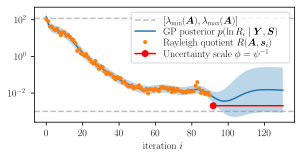

In [14]:
# Figure and setup
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 2), sharex=True, squeeze=False)
pred_iters = np.arange(1, info_pls["iter"] + 41)

# Predict log Rayleigh quotient
GP_pred = m.predict(pred_iters[:, None])
a_pred_GPmean = GP_pred[0].ravel()  # + beta0
a_pred_GP2std = 2 * np.sqrt(GP_pred[1].ravel())

# Plot
axes[0, 0].axhline(
    y=np.max(eigs),
    color="gray",
    alpha=0.5,
    linestyle="--",
    label="$[\\lambda_{\\min}(\\bm{A}), \\lambda_{\\max}(\\bm{A})]$",
)
axes[0, 0].axhline(y=np.min(eigs), color="gray", alpha=0.5, linestyle="--")
axes[0, 0].fill_between(
    x=pred_iters - 1,
    y1=np.exp(a_pred_GPmean - a_pred_GP2std),
    y2=np.exp(a_pred_GPmean + a_pred_GP2std),
    alpha=0.3,
)
axes[0, 0].plot(
    pred_iters - 1,
    np.exp(a_pred_GPmean),
    label="GP posterior $p(\\ln R_i \\mid \\bm{Y}, \\bm{S})$",
)
axes[0, 0].plot(iters, a_proj, ".", label="Rayleigh quotient $R(\\bm{A}, \\bm{s}_{i})$")
axes[0, 0].axhline(
    y=phi,
    xmin=iters[-1] / pred_iters[-1],
    xmax=0.955,
    label="Uncertainty scale $\\phi=\psi^{-1}$",
    color="red",
    linestyle="-",
    marker="o",
    markevery=1.0,
)
axes[0, 0].set_xlabel("iteration $i$")
axes[0, 0].set_yscale("log")

plt.legend(fontsize=10, labelspacing=0.1)
plt.tight_layout(pad=0)

# Save to file
fig.savefig("../../figures/rayleigh_quotient.pdf", bbox_inches="tight", pad_inches=0.0)

In [10]:
print(mf)

  mapping.          |               value  |  constraints  |  priors
  constmap.C        |  3.1027943267384566  |               |        
  mapping.linmap.A  |       [-1.50699398]  |               |        


## Uncertainty Calibration

We measure the effect of the calibration procedure by computing the log-ratio between the numerical uncertainty and the true error in euclidean norm.

In [11]:
import scipy.sparse.linalg

# Solve with probabilistic linear solver
xhat, Ahat, Ainvhat, info_pls = problinsolve(A=A, b=b, maxiter=n, calibration="gpkern")

In [12]:
print(info_pls)

{'iter': 91, 'maxiter': 1000, 'resid_l2norm': 0.0002131394178095624, 'trace_sol_cov': 0.3584085777962431, 'conv_crit': 'resid_rtol', 'rel_cond': None}


In [13]:
sigma_trace = info_pls["trace_sol_cov"]
print("\sqrt(trace(Sigma)) = " + str(np.sqrt(sigma_trace)))
l2_error = np.linalg.norm(x_true.ravel() - xhat.mean.ravel(), ord=2)
print(f"l2-error = {l2_error}")
print(f"test statistic w = {0.5 * np.log(sigma_trace) - np.log(l2_error)}")

\sqrt(trace(Sigma)) = 0.5986723459424554
l2-error = 0.04591197892630837
test statistic w = 2.567988384885754
